# Image Recognition with PCA - Lab

## Introduction

In this lab, you'll explore the classic MNIST dataset of handwritten digits. While not as large as the previous dataset on facial image recognition, it still provides a 64-dimensional dataset that is ripe for feature reduction.

## Objectives

In this lab you will: 

- Use PCA to discover the principal components with images 
- Use the principal components of  a dataset as features in a machine learning model 
- Calculate the time savings and performance gains of layering in PCA as a preprocessing step in machine learning pipelines 

## Load the data

Load the `load_digits` dataset from the `datasets` module of scikit-learn. 

In [4]:
# Load the dataset
import sklearn.datasets as skdata
data = skdata.load_digits()
print(data.data.shape, data.target.shape)

(1797, 64) (1797,)


## Preview the dataset

Now that the dataset is loaded, display the first 20 images.

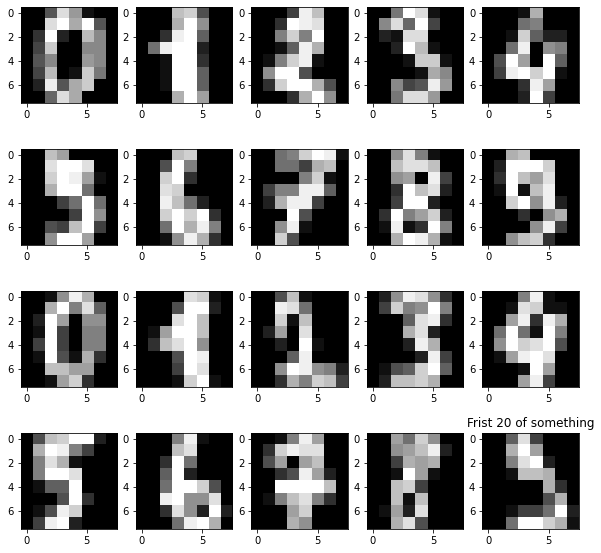

In [6]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10,10))
for n in range(20):
    i = n //5
    j = n%5
    ax = axes[i][j]
    ax.imshow(data.images[n], cmap=plt.cm.gray)
plt.title('Frist 20 of something');

## Baseline model

Now it's time to fit an initial baseline model. 

- Split the data into training and test sets. Set `random_state=22` 
- Fit a support vector machine to the dataset. Set `gamma='auto'` 
- Record the training time 
- Print the training and test accucary of the model 

In [13]:
# Split the data
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X,y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1347, 64) (450, 64) (1347,) (450,)


In [20]:
# Fit a naive model 
clf = SVC(gamma = 'auto', random_state = 22)
%timeit clf.fit(X_train, y_train)
y_train_hat = clf.predict(X_train)
y_test_hat = clf.predict(X_test)


999 ms ± 94.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
import sklearn.metrics as skm

train_acc = skm.accuracy_score(y_train, y_train_hat)
test_acc = skm.accuracy_score(y_test, y_test_hat)
print('Training Accuracy: {}\nTesting Accuracy: {}'.format(train_acc, test_acc))

Training Accuracy: 1.0
Testing Accuracy: 0.4688888888888889


### Grid search baseline

Refine the initial model by performing a grid search to tune the hyperparameters. The two most important parameters to adjust are `'C'` and `'gamma'`. Once again, be sure to record the training time as well as the training and test accuracy.

In [36]:
# Your code here
# ⏰ Your code may take several minutes to run
import numpy as np
from sklearn.model_selection import GridSearchCV

gridSearch = GridSearchCV(
    estimator = SVC(),
    param_grid = {
        'C' : np.linspace(1,20,2),
        'gamma' : ['scale', 'auto']
    },
    scoring = 'accuracy',
    n_jobs = -1
)
%timeit gridSearch.fit(X_train, y_train)
y_train_hat = gridSearch.predict(X_train)
y_test_hat = gridSearch.predict(X_test)

1.16 s ± 51.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
# Print the best parameters 
gridSearch.best_params_

{'C': 20.0, 'gamma': 'scale'}

In [38]:
# Print the training and test accuracy 
train_acc = skm.accuracy_score(y_train, y_train_hat)
test_acc = skm.accuracy_score(y_test, y_test_hat)
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_acc, test_acc))

Training Accuracy: 1.0	Testing Accuracy: 0.9933333333333333


## Compressing with PCA

Now that you've fit a baseline classifier, it's time to explore the impacts of using PCA as a preprocessing technique. To start, perform PCA on `X_train`. (Be sure to only fit PCA to `X_train`; you don't want to leak any information from the test set.) Also, don't reduce the number of features quite yet. You'll determine the number of features needed to account for 95% of the overall variance momentarily.

In [73]:
# Your code here
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

def pipe_with_n_pca (n):
    pipeline = Pipeline(
        steps = [
            ('pca', PCA(n_components = n)),
            ('grid_search', GridSearchCV(
                estimator = SVC(),
                param_grid = {
                    'C' : np.linspace(1,20,10),
                    'gamma' : ['scale','auto']
                },
                scoring = 'accuracy',
                n_jobs = -1))])
    pipeline.fit(X_train, y_train)
    y_train_hat = pipeline.predict(X_train)
    y_test_hat = pipeline.predict(X_test)
    print(f'Accuracy for training set: {skm.accuracy_score(y_train, y_train_hat)}')
    print(f'Accuracy for testing set:  {skm.accuracy_score(y_test, y_test_hat)}')
    print()
    return pipeline
def percent_cleared(n, X, y):
    pca = PCA(n_components = n)
    pca.fit(X, y)
    return pca.explained_variance_ratio_.sum()

In [55]:
%timeit pipeline.fit(X_train, y_train)

1.35 s ± 63.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Plot the explained variance versus the number of features

In order to determine the number of features you wish to reduce the dataset to, it is sensible to plot the overall variance accounted for by the first $n$ principal components. Create a graph of the variance explained versus the number of principal components.

Text(0, 0.5, 'percent captured')

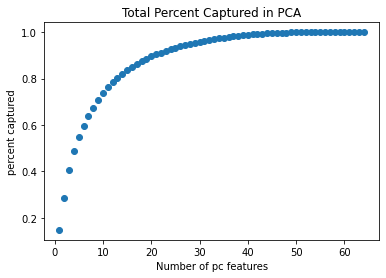

In [59]:
x_vector = np.linspace(1, 64, 64)
y_vector = [percent_cleared(int(i), X_train, y_train) for i in x_vector]
plt.scatter(x_vector, y_vector)
plt.title('Total Percent Captured in PCA')
plt.xlabel('Number of pc features')
plt.ylabel('percent captured')

## Determine the number of features to capture 95% of the variance

Great! Now determine the number of features needed to capture 95% of the dataset's overall variance.

In [69]:
def find_percent_captured(number):
    for i in range(data.data.shape[0]):
        percent = percent_cleared(i, X_train, y_train)
        if percent < .95:
            continue
        else:
            return i

In [70]:
find_percent_captured(.95)

28

## Subset the dataset to these principal components which capture 95% of the overall variance

Use your knowledge to reproject the dataset into a lower-dimensional space using PCA. 

In [74]:
%timeit pipe_with_n_pca(28)


Accuracy for training set: 0.9977728285077951

Accuracy for testing set:  0.9911111111111112
Accuracy for training set: 0.9977728285077951

Accuracy for testing set:  0.9911111111111112
Accuracy for training set: 0.9977728285077951

Accuracy for testing set:  0.9911111111111112
Accuracy for training set: 0.9977728285077951

Accuracy for testing set:  0.9911111111111112
Accuracy for training set: 0.9977728285077951

Accuracy for testing set:  0.9911111111111112
Accuracy for training set: 0.9977728285077951

Accuracy for testing set:  0.9911111111111112
Accuracy for training set: 0.9977728285077951

Accuracy for testing set:  0.9911111111111112
Accuracy for training set: 0.9977728285077951

Accuracy for testing set:  0.9911111111111112
2.66 s ± 91.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Refit a model on the compressed dataset

Now, refit a classification model to the compressed dataset. Be sure to time the required training time, as well as the test and training accuracy.

In [ ]:
# Your code here

### Grid search

Finally, use grid search to find optimal hyperparameters for the classifier on the reduced dataset. Be sure to record the time required to fit the model, the optimal hyperparameters and the test and train accuracy of the resulting model.

In [ ]:
# Your code here
# ⏰ Your code may take several minutes to run

In [ ]:
# Print the best parameters 


In [ ]:
# Print the training and test accuracy 
train_acc = None
test_acc = None
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_acc, test_acc))

## Summary

Well done! In this lab, you employed PCA to reduce a high dimensional dataset. With this, you observed the potential cost benefits required to train a model and performance gains of the model itself.